<a href="https://colab.research.google.com/github/GardnerL16/GardnerL16.github.io/blob/master/HW_p4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install celluloid
! pip install torch

In [2]:
# Libraries
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import cv2
import itertools
from google.colab.patches import cv2_imshow
import numpy as np
from celluloid import Camera
from IPython.display import HTML
%matplotlib inline

In [3]:
def cuda2numpy(a):
    return a.data.detach().cpu().numpy()

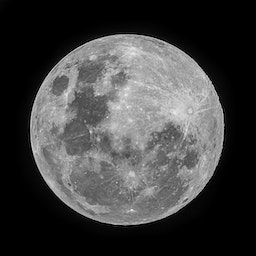

In [7]:
#Step 1: Import and setup variables

#Load in image and convert to grayscale
moon=cv2.imread("moon.jpg")
gray = cv2.cvtColor(moon, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray)

#Develop X as a meshgrid
I=torch.tensor(np.arange(0,256))
J=torch.tensor(np.arange(0,256))

x1,x2=torch.meshgrid(I,J,indexing='ij')

X = torch.stack((x1, x2), dim=-1)
X = X.view(-1, 2)

Y_T = torch.tensor(gray, dtype=torch.float32).view(-1, 1)

# Rescale X and Y
X=X/255
Y_T=Y_T/255


In [8]:
#Step 2 Define the model
class SinusoidalActivation(nn.Module):
    def __init__(self, w_i=30):
        super(SinusoidalActivation, self).__init__()
        self.w_i = w_i

    def forward(self, x):
      if x.dim() != 2:
        raise ValueError("Input tensor must be 2D")

      return torch.sin(self.w_i*x)

class MLP(nn.Module):
  def __init__(self,architecture=[2,100,100,1],activation='sigmoid'):
        super(MLP, self).__init__()
        self.architecture=architecture
        if activation=='sigmoid':
          self.activation=nn.Sigmoid()
        elif activation=='relu':
          self.activation=nn.ReLU()
        elif activation == 'sinusoidal':
          self.activation = SinusoidalActivation()
        else:
          print('Activation not recognized! Using LeakyReLU instead.')
          self.activation=nn.LeakyReLU()
        arch=[]
        linear_layers = []
        activation_functions = []
        for i in range(1, len(architecture) - 1):
          linear_layer = nn.Linear(architecture[i-1], architecture[i])
          linear_layer.weight.data = linear_layer.weight.data.float()  # Set weight data type to float32
          linear_layer.bias.data = linear_layer.bias.data.float()  # Set bias data type to float32
          linear_layers.append(linear_layer)
          activation_functions.append(self.activation)

        self.basis = nn.Sequential(*list(itertools.chain.from_iterable(zip(linear_layers, activation_functions))))
        self.regressor = nn.Linear(architecture[-2], architecture[-1])


  def forward(self,f):
        assert f.shape[1]==self.architecture[0]
        z=self.basis(f)
        out=self.regressor(z)
        return out

In [17]:
#Step 3: Setup optimizer
lr=1e-2
n_epochs=1000

model=MLP(architecture=[2, 100, 100, 1],activation='sinusoidal')
optim=torch.optim.SGD(model.parameters(),lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optim,milestones=[250,500],
                                                  gamma=0.1)
for param in model.parameters():
    param.data = param.data.float()

In [18]:
#Step 4: Define Objective/loss fuction
objective=nn.MSELoss().float()
fig=plt.figure(figsize=(7,5))
camera=Camera(fig)
batchsize=256
plot_interval=20

loss_over_time=[]

for n in range(n_epochs):
  ind=np.random.permutation(256*256)
  t_loss=0.0
  for i in range(int (256*256/batchsize)):
    batchind=ind[i*batchsize:(i+1)*batchsize]
    f=model(X[batchind].float())
    loss=objective(f,Y_T[batchind].float())
    t_loss += loss.item()
    loss_over_time.append(loss.item())
    loss.backward()
    optim.step()
    optim.zero_grad()

  scheduler.step()

  print(f'Epoch {n + 1}/{n_epochs}, Loss: {t_loss / (256 * 256 / batchsize)}')

average_loss = t_loss



Epoch 1/1000, Loss: 0.111267452390166
Epoch 2/1000, Loss: 0.06508578058856074
Epoch 3/1000, Loss: 0.05839831684716046
Epoch 4/1000, Loss: 0.054654260515235364
Epoch 5/1000, Loss: 0.05131082456500735
Epoch 6/1000, Loss: 0.04943109815940261
Epoch 7/1000, Loss: 0.047497061459580436
Epoch 8/1000, Loss: 0.04524696571752429
Epoch 9/1000, Loss: 0.045213191260700114
Epoch 10/1000, Loss: 0.04324797436129302
Epoch 11/1000, Loss: 0.04277762312995037
Epoch 12/1000, Loss: 0.04184034821810201
Epoch 13/1000, Loss: 0.040831570186128374
Epoch 14/1000, Loss: 0.03955427763867192
Epoch 15/1000, Loss: 0.03882853568211431
Epoch 16/1000, Loss: 0.03852342112804763
Epoch 17/1000, Loss: 0.03801084903534502
Epoch 18/1000, Loss: 0.036207231889420655
Epoch 19/1000, Loss: 0.03657491402555024
Epoch 20/1000, Loss: 0.03588763871084666
Epoch 21/1000, Loss: 0.03493835443077842
Epoch 22/1000, Loss: 0.03479253534896998
Epoch 23/1000, Loss: 0.03424863892723806
Epoch 24/1000, Loss: 0.03237876909406623
Epoch 25/1000, Loss: 0

<Figure size 700x500 with 0 Axes>

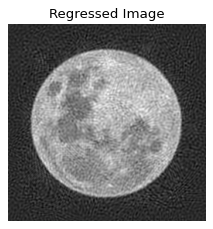

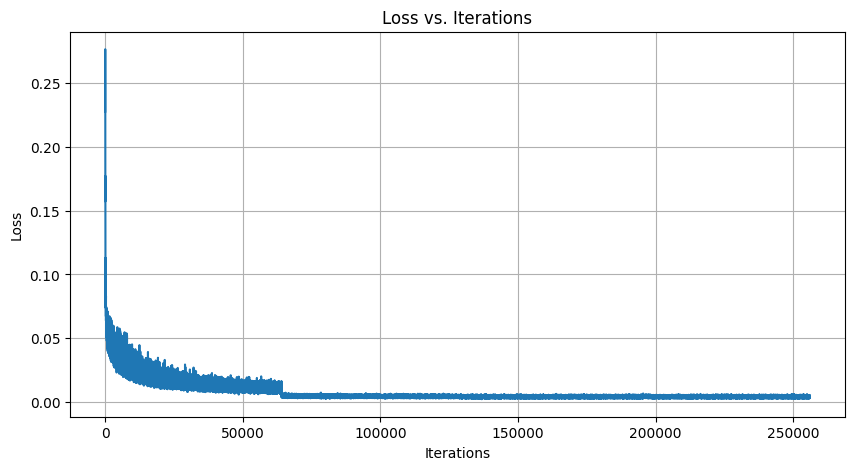

In [19]:
# Step 5: Plot the regressed image
with torch.no_grad():
    xx, yy = torch.meshgrid(torch.linspace(0, 1, 256), torch.linspace(0, 1, 256))
    grid_points = torch.stack((xx, yy), dim=-1).view(-1, 2)
    predicted_image = model(grid_points.float()).view(256, 256).numpy()

# Display the final regressed image
plt.figure(figsize=(256/80, 256/80), dpi=80)
plt.imshow(predicted_image, cmap="gray")
plt.title("Regressed Image")
plt.axis("off")
plt.show()

# Plot loss over time
plt.figure(figsize=(10, 5))
plt.plot(loss_over_time)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss vs. Iterations")
plt.grid(True)
#plt.show()

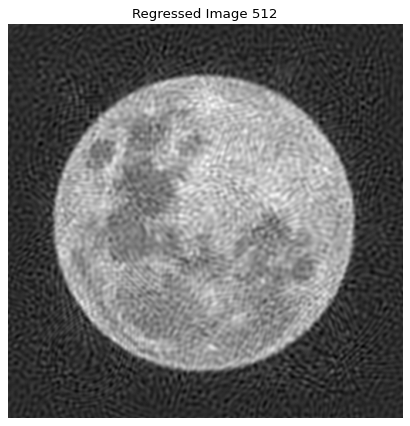

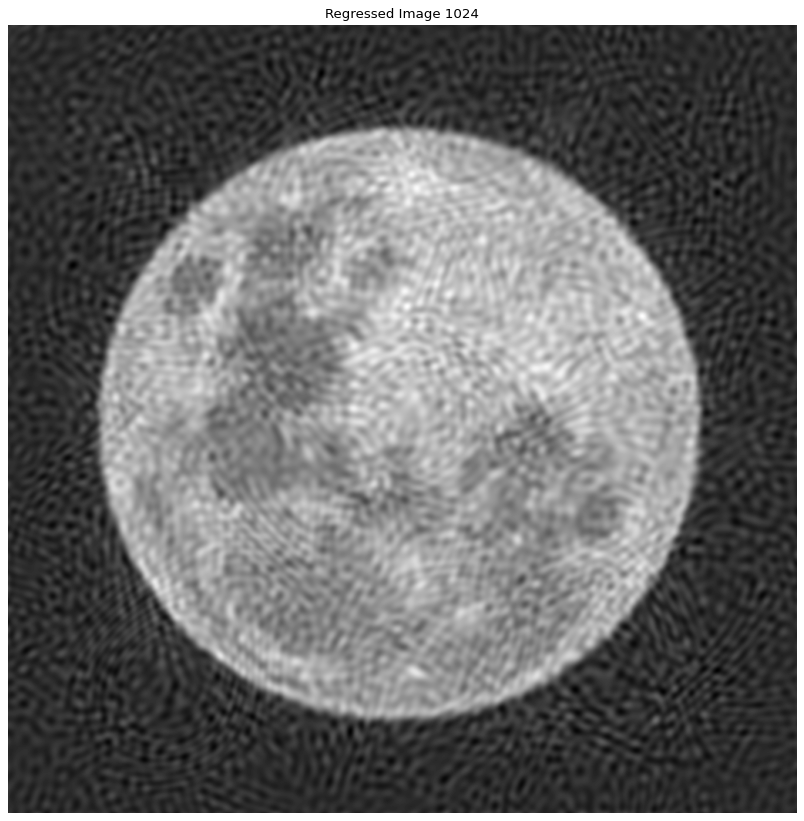

In [26]:
#Step 6: Increase sampling grid resolution and evaluate trained model

# 512
with torch.no_grad():
    xx, yy = torch.meshgrid(torch.linspace(0, 1, 512), torch.linspace(0, 1, 512))
    grid_points = torch.stack((xx, yy), dim=-1).view(-1, 2)
    predicted_image512 = model(grid_points.float()).view(512, 512).numpy()

# Display the final regressed image
plt.figure(figsize=(512/80, 512/80), dpi=80)
plt.imshow(predicted_image512, cmap="gray")
plt.title("Regressed Image 512")
plt.axis("off")
plt.show()

#1024
with torch.no_grad():
    xx, yy = torch.meshgrid(torch.linspace(0, 1, 1024), torch.linspace(0, 1, 1024))
    grid_points = torch.stack((xx, yy), dim=-1).view(-1, 2)
    predicted_image_1024 = model(grid_points.float()).view(1024, 1024).numpy()

# Display the final regressed image
plt.figure(figsize=(1024/80, 1024/80), dpi=80)
plt.imshow(predicted_image_1024, cmap="gray")
plt.title("Regressed Image 1024")
plt.axis("off")
plt.show()
